In [160]:
import pandas as pd
import numpy as np
import tensorflow as tf 
import random
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from scikeras.wrappers import KerasRegressor


##### Model to include best params & sentiment scores

Load sentiment scores

In [161]:
# Load both sentiment files
sent1 = pd.read_csv('../../curr_news/aggregated_daily_sentiment.csv')
sent2 = pd.read_csv('../../historic_news/aggregated_daily_sentiment.csv')

# Combine them in order: part 1 comes before part 2
sentiment = pd.concat([sent1, sent2], ignore_index=True)

# Rename and parse dates
sentiment.rename(columns={'Unnamed: 0': 'Datetime'}, inplace=True)
sentiment['Datetime'] = pd.to_datetime(sentiment['Datetime'])

# Reshape to long format: Date | Coin | Sentiment
sentiment = sentiment.melt(id_vars='Datetime', var_name='Coin', value_name='Sentiment')
sentiment['Datetime'] = sentiment['Datetime'].dt.normalize()
sentiment['Datetime'] = sentiment['Datetime'].dt.tz_localize(None)



In [162]:
# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)
tf.keras.utils.set_random_seed(42)
tf.config.experimental.enable_op_determinism() 


#Code for Hyperparameter Tuning
def load_and_preprocess_data(file_path, sentiment=sentiment):
    df = pd.read_csv(file_path)
    df['Datetime'] = df['Date']
    df['Datetime'] = pd.to_datetime(df['Datetime'])
    df.sort_values(['Coin', 'Datetime'], inplace=True)
    # Prepare crypto data date column
    df['Datetime'] = df['Datetime'].dt.normalize()
    df['Datetime'] = df['Datetime'].dt.tz_localize(None)

    # Merge daily sentiment into intraday stock data
    df = pd.merge(df, sentiment, how='left', on=['Datetime', 'Coin'])

    # Fill any missing sentiment values with neutral (0)
    df['Sentiment'] = df['Sentiment'].fillna(0)
        
    df['Return'] = df.groupby('Coin')['Close'].pct_change().shift(-1)  # Next period return as target
    non_features = ['Datetime', 'Coin', 'Date', 'Return']
    feature_cols = [x for x in list(df.columns) if x not in non_features]
    df = df[feature_cols + non_features].dropna()
    df.dropna(inplace=True)
    
    return df, feature_cols

# Prepare sequences for LSTM training
def prepare_sequences(df, feature_cols, sequence_length=20):
    #feature_scaler = RobustScaler()
    #return_scaler = RobustScaler()
    feature_scaler = MinMaxScaler(feature_range=(0, 1))
    return_scaler = MinMaxScaler(feature_range=(0, 1))
    
    X_scaled = feature_scaler.fit_transform(df[feature_cols])
    y_scaled = return_scaler.fit_transform(df[['Return']])
    
    X_sequences, y_sequences, dates, close_prices = [], [], df['Datetime'].values[sequence_length:], df['Close'].values[sequence_length:]
    
    for i in range(len(X_scaled) - sequence_length):
        X_sequences.append(X_scaled[i:i+sequence_length])
        y_sequences.append(y_scaled[i+sequence_length])
    
    return np.array(X_sequences), np.array(y_sequences), dates, close_prices, return_scaler

# Split data into training and testing sets
def split_data(X, y, dates, close_prices, train_ratio=0.8):
    split_index = int(len(X) * train_ratio)
    return X[:split_index], X[split_index:], y[:split_index], y[split_index:], dates[split_index:], close_prices[split_index:]



# Function to create model for GridSearchCV
def create_lstm_model(input_shape, layers=1, units_1=50, units_2=50, dropout_rate=0.2, learning_rate=0.001, optimizer='adam'):
    model = Sequential()  # Add this line to initialize the model
    # Explicitly define the input layer
    model.add(Input(shape=input_shape))  # Fix: Define input layer separately
    # First LSTM layer
    if layers == 1:
        
        model.add(LSTM(units=units_1))
    else:
        model.add(LSTM(units=units_1, return_sequences=True))
        model.add(Dropout(dropout_rate))
        
        # Additional LSTM layers
        for i in range(layers-2):
            model.add(LSTM(units=units_2, return_sequences=True))
            model.add(Dropout(dropout_rate))
        
        # Final LSTM layer
        model.add(LSTM(units=units_2))

    model.add(Dropout(dropout_rate))
    model.add(Dense(units=1))  # Output layer
    # Convert optimizer string to actual optimizer instance
    optimizer_instance = {
        'adam': tf.keras.optimizers.Adam(learning_rate=learning_rate),
        'rmsprop': tf.keras.optimizers.RMSprop(learning_rate=learning_rate),
        'sgd': tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
    }[optimizer]
    model.compile(optimizer=optimizer_instance,
                    loss='mse',
                    metrics=['mae'])
    return model
# Function to train and evaluate the model
def train_and_evaluate_model(df, feature_cols, coin):
    df_coin = df[df['Coin'] == coin]
    X, y, dates, close_prices, return_scaler = prepare_sequences(df_coin, feature_cols)

    # Train-test split (first 80% train, last 20% test)
    X_train, X_test, y_train, y_test, dates_test, close_prices_test = split_data(X, y, dates, close_prices)
    
    # Hyperparameter tuning
    input_shape = (X_train.shape[1], X_train.shape[2])
    # Learning rate adjustment and early stopping
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
    ]
    if coin == 'BTC':
        model = create_lstm_model(input_shape, layers=1, units_1=100, units_2=50, dropout_rate=0.2, learning_rate=0.001, optimizer='adam')
        model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), callbacks=callbacks)
    
    elif coin == 'ETH':
        model = create_lstm_model(input_shape, layers=1, units_1=100, units_2=50, dropout_rate=0.2, learning_rate=0.001, optimizer='adam')
        model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test, y_test), callbacks=callbacks)
    elif coin == 'SOL':
        model = create_lstm_model(input_shape, layers=1, units_1=100, units_2=50, dropout_rate=0.4, learning_rate=0.001, optimizer='adam')
        model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test), callbacks=callbacks)
    elif coin == 'XRP':
        model = create_lstm_model(input_shape, layers=1, units_1=100, units_2=50, dropout_rate=0.4, learning_rate=0.001, optimizer='adam')
        model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), callbacks=callbacks)
    
    # Predict and rescale returns
    y_pred_scaled = model.predict(X_test)
    y_pred = return_scaler.inverse_transform(y_pred_scaled)
    y_test = return_scaler.inverse_transform(y_test.reshape(-1, 1))
    
    return model, y_test, y_pred, dates_test, close_prices_test 



In [163]:
# Function to log trades and calculate cumulative return
def log_trades(dates, actual_returns, predicted_returns, close_prices, coin):
    positions = ['LONG' if pred > 0 else 'SHORT' for pred in predicted_returns.flatten()]
    '''
    fee = 1e-3  # Trading fee (0.1% on Binance)
    strategy_returns = np.zeros_like(actual_returns.flatten())

    prev_position = None
    for i in range(len(actual_returns)):
        curr_position = positions[i]

        # Determine base return based on position
        if curr_position == 'LONG':
            ret = actual_returns[i]
        elif curr_position == 'SHORT':
            ret = -actual_returns[i]
        else:
            ret = 0

        # Apply fee only if position changed
        if prev_position is not None and curr_position != prev_position:
            ret -= fee

        strategy_returns[i] = ret
        prev_position = curr_position
    
    # Compute cumulative return
    cumulative_return = np.cumprod(1 + strategy_returns) - 1'
    '''
    cumulative_return = np.cumprod(1 + (actual_returns * (np.array(positions) == 'LONG') - actual_returns * (np.array(positions) == 'SHORT'))) - 1
    trades = pd.DataFrame({
        'Date': dates,
        'Stock_Close_Price': close_prices,
        'Predicted_Return': predicted_returns.flatten(),
        'Actual_Return': actual_returns,
        'Position': positions,
        'Cumulative_Return': cumulative_return,
        'Coin': coin
    })
    
    return trades 

# Function to plot cumulative returns for each stock
def plot_cumulative_returns(all_trades_df):
    plt.figure(figsize=(12, 6))
    for coin in all_trades_df['Coin'].unique():
        df_coin = all_trades_df[all_trades_df['Coin'] == coin]
        plt.plot(df_coin['Date'], df_coin['Cumulative_Return'], label=coin)
    
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return')
    plt.title('Cumulative Returns for Each Cryptocurrency')
    plt.legend()
    plt.xticks(rotation=45)
    plt.show()

In [164]:
file_path = "./data_with_indicators/crypto_prices_1m_with_indicators.csv"
df, feature_cols = load_and_preprocess_data(file_path)

In [165]:

all_trades = []
unique_coins = ['BTC', 'ETH', 'SOL', 'XRP']


In [166]:
coin = 'BTC'
print(f"Processing {coin}...")
b_model, b_y_test, b_y_pred, b_dates_test, b_close_prices_test = train_and_evaluate_model(df, feature_cols, coin)


Processing BTC...
Epoch 1/50


2025-03-30 15:38:30.525599: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-03-30 15:38:30.526018: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

2121/2123 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0069 - mae: 0.0494

2025-03-30 15:38:43.641177: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-03-30 15:38:43.641617: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

2123/2123 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - loss: 0.0069 - mae: 0.0493 - val_loss: 4.8494e-04 - val_mae: 0.0142 - learning_rate: 0.0010
Epoch 2/50
2123/2123 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - loss: 7.5062e-04 - mae: 0.0201 - val_loss: 5.6515e-04 - val_mae: 0.0164 - learning_rate: 0.0010
Epoch 3/50
2123/2123 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - loss: 5.3113e-04 - mae: 0.0159 - val_loss: 4.7140e-04 - val_mae: 0.0136 - learning_rate: 0.0010
Epoch 4/50
2123/2123 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - loss: 4.6000e-04 - mae: 0.0141 - val_loss: 4.6833e-04 - val_mae: 0.0137 - learning_rate: 0.0010
Epoch 5/50
2123/2123 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - loss: 4.3204e-04 - mae: 0.0132 - val_loss: 4.6786e-04 - val_mae: 0.0136 - learning_rate: 5.0000e-04
Epoch 6/50
2123/2123 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - loss: 4.3106e-04 - mae: 0.0132 - val_loss: 4.6838e-04 - val_mae: 0.0137 - learning_rate: 5.0000e-04
Epoch 7/50
2123/2123 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - loss: 4.2878e-04 - mae: 0.0131 -

2025-03-30 15:40:52.303022: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-03-30 15:40:52.303478: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

531/531 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


In [167]:
btc_trades = log_trades(b_dates_test, b_y_test.flatten(), b_y_pred.flatten(), b_close_prices_test, coin)
all_trades.append(btc_trades)

In [168]:
coin = 'ETH'
print(f"Processing {coin}...")
e_model, e_y_test, e_y_pred, e_dates_test, e_close_prices_test = train_and_evaluate_model(df, feature_cols, coin)


Processing ETH...
Epoch 1/50
1061/1062 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0076 - mae: 0.0574

2025-03-30 15:41:05.079617: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-03-30 15:41:05.080093: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

1062/1062 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - loss: 0.0076 - mae: 0.0574 - val_loss: 1.6846e-04 - val_mae: 0.0099 - learning_rate: 0.0010
Epoch 2/50
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - loss: 0.0010 - mae: 0.0250 - val_loss: 8.8732e-05 - val_mae: 0.0066 - learning_rate: 0.0010
Epoch 3/50
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - loss: 6.3525e-04 - mae: 0.0198 - val_loss: 8.5390e-05 - val_mae: 0.0065 - learning_rate: 0.0010
Epoch 4/50
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - loss: 3.6090e-04 - mae: 0.0147 - val_loss: 7.5474e-05 - val_mae: 0.0058 - learning_rate: 0.0010
Epoch 5/50
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - loss: 1.9769e-04 - mae: 0.0106 - val_loss: 8.2408e-05 - val_mae: 0.0064 - learning_rate: 5.0000e-04
Epoch 6/50
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - loss: 1.4052e-04 - mae: 0.0086 - val_loss: 8.3702e-05 - val_mae: 0.0064 - learning_rate: 5.0000e-04
Epoch 7/50
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - loss: 1.0441e-04 - mae: 0.007

2025-03-30 15:43:45.045603: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-03-30 15:43:45.046301: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

531/531 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


In [169]:
# Log trades and update cumulative returns
eth_trades = log_trades(e_dates_test, e_y_test.flatten(), e_y_pred.flatten(), e_close_prices_test, coin)
all_trades.append(eth_trades)

In [170]:
coin = 'SOL'
print(f"Processing {coin}...")
s_model, s_y_test, s_y_pred, s_dates_test, s_close_prices_test = train_and_evaluate_model(df, feature_cols, coin)


Processing SOL...
Epoch 1/50
4243/4246 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0109 - mae: 0.0613

2025-03-30 15:44:12.935227: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-03-30 15:44:12.935648: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

4246/4246 ━━━━━━━━━━━━━━━━━━━━ 28s 6ms/step - loss: 0.0109 - mae: 0.0613 - val_loss: 0.0013 - val_mae: 0.0252 - learning_rate: 0.0010
Epoch 2/50
4246/4246 ━━━━━━━━━━━━━━━━━━━━ 25s 6ms/step - loss: 0.0013 - mae: 0.0245 - val_loss: 0.0013 - val_mae: 0.0249 - learning_rate: 0.0010
Epoch 3/50
4246/4246 ━━━━━━━━━━━━━━━━━━━━ 25s 6ms/step - loss: 0.0012 - mae: 0.0225 - val_loss: 0.0013 - val_mae: 0.0249 - learning_rate: 0.0010
Epoch 4/50
4246/4246 ━━━━━━━━━━━━━━━━━━━━ 25s 6ms/step - loss: 0.0012 - mae: 0.0223 - val_loss: 0.0013 - val_mae: 0.0249 - learning_rate: 0.0010
Epoch 5/50
4246/4246 ━━━━━━━━━━━━━━━━━━━━ 25s 6ms/step - loss: 0.0012 - mae: 0.0222 - val_loss: 0.0013 - val_mae: 0.0249 - learning_rate: 5.0000e-04
Epoch 6/50
4246/4246 ━━━━━━━━━━━━━━━━━━━━ 26s 6ms/step - loss: 0.0012 - mae: 0.0222 - val_loss: 0.0013 - val_mae: 0.0249 - learning_rate: 5.0000e-04
Epoch 7/50
4246/4246 ━━━━━━━━━━━━━━━━━━━━ 25s 6ms/step - loss: 0.0012 - mae: 0.0222 - val_loss: 0.0013 - val_mae: 0.0249 - learning_r

2025-03-30 15:49:30.328221: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-03-30 15:49:30.328788: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

531/531 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


In [171]:
# Log trades and update cumulative returns
sol_trades = log_trades(s_dates_test, s_y_test.flatten(), s_y_pred.flatten(), s_close_prices_test, coin)
all_trades.append(sol_trades)

In [172]:
coin = 'XRP'
print(f"Processing {coin}...")
xrp_model, xrp_y_test, xrp_y_pred, xrp_dates_test, xrp_close_prices_test = train_and_evaluate_model(df, feature_cols, coin)


Processing XRP...
Epoch 1/50
2119/2123 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0115 - mae: 0.0622

2025-03-30 15:49:54.398252: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-03-30 15:49:54.398801: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

2123/2123 ━━━━━━━━━━━━━━━━━━━━ 23s 10ms/step - loss: 0.0115 - mae: 0.0621 - val_loss: 2.3455e-04 - val_mae: 0.0122 - learning_rate: 0.0010
Epoch 2/50
2123/2123 ━━━━━━━━━━━━━━━━━━━━ 21s 10ms/step - loss: 5.7624e-04 - mae: 0.0183 - val_loss: 1.2862e-04 - val_mae: 0.0078 - learning_rate: 0.0010
Epoch 3/50
2123/2123 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - loss: 1.9043e-04 - mae: 0.0094 - val_loss: 1.3627e-04 - val_mae: 0.0082 - learning_rate: 0.0010
Epoch 4/50
2123/2123 ━━━━━━━━━━━━━━━━━━━━ 19s 9ms/step - loss: 1.6734e-04 - mae: 0.0084 - val_loss: 1.2495e-04 - val_mae: 0.0076 - learning_rate: 0.0010
Epoch 5/50
2123/2123 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - loss: 1.6279e-04 - mae: 0.0082 - val_loss: 1.2610e-04 - val_mae: 0.0076 - learning_rate: 0.0010
Epoch 6/50
2123/2123 ━━━━━━━━━━━━━━━━━━━━ 20s 10ms/step - loss: 1.5755e-04 - mae: 0.0080 - val_loss: 1.2471e-04 - val_mae: 0.0076 - learning_rate: 5.0000e-04
Epoch 7/50
2123/2123 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - loss: 1.5713e-04 - mae: 0.0080 - 

2025-03-30 15:53:03.664145: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-03-30 15:53:03.664667: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

531/531 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [173]:
# Log trades and update cumulative returns
xrp_trades = log_trades(xrp_dates_test, xrp_y_test.flatten(), xrp_y_pred.flatten(), xrp_close_prices_test, coin)
all_trades.append(xrp_trades)

In [174]:
all_trades = [btc_trades, eth_trades, sol_trades, xrp_trades]

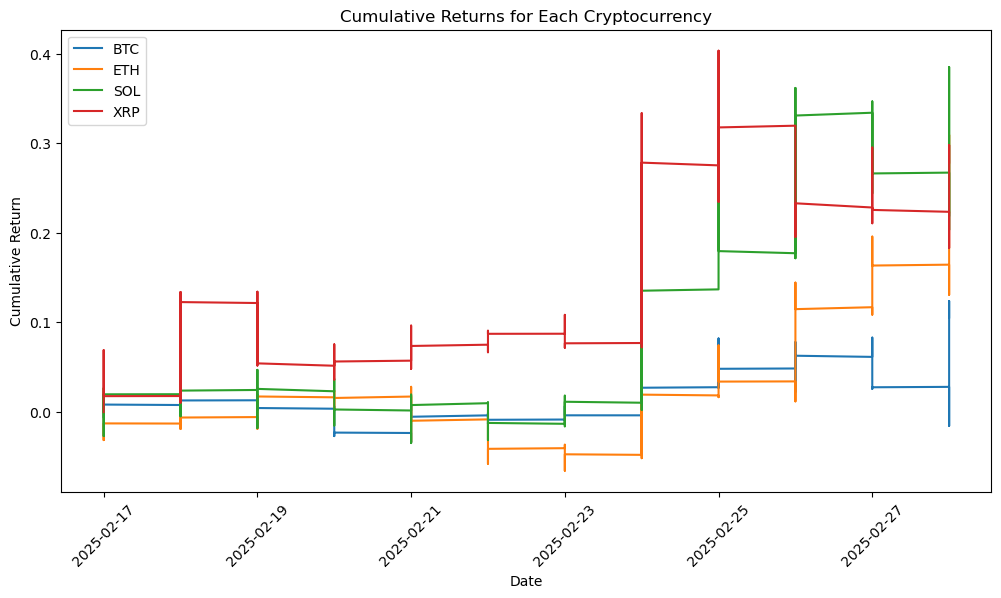

In [175]:

# Combine all trades into a single DataFrame
all_trades_df = pd.concat(all_trades, ignore_index=True)

# Plot cumulative returns for all stocks
plot_cumulative_returns(all_trades_df)

In [176]:
all_trades_df['Rolling_Risk'] = all_trades_df.groupby('Coin')['Actual_Return'].transform(lambda x: x.rolling(window=10).std())
all_trades_df['Rolling_Average'] = all_trades_df.groupby('Coin')['Actual_Return'].transform(lambda x: x.rolling(window=10).mean())


In [177]:
all_trades_df.to_csv("returns.csv")

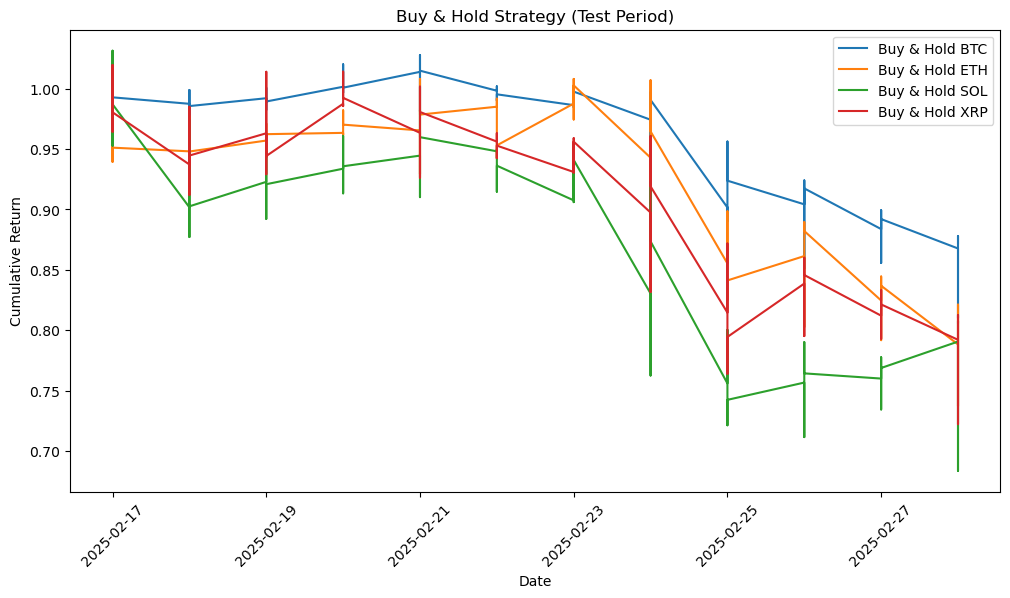

In [178]:
# Reload the dataset
file_path = "./data_with_indicators/crypto_prices_1m_with_indicators.csv"
df, feature_cols = load_and_preprocess_data(file_path)

# Function to plot Buy & Hold strategy for the test period (last 20% of the dataset)
def plot_buy_and_hold_test_period(df):
    plt.figure(figsize=(12, 6))

    for coin in df['Coin'].unique():
        df_coin = df[df['Coin'] == coin].sort_values('Datetime')

        # Split data (80% train, 20% test)
        split_index = int(len(df_coin) * 0.8)
        df_test = df_coin.iloc[split_index:]  # Select last 20%

        if df_test.empty:
            continue  # Skip if no test data

        initial_price = df_test['Close'].iloc[0]
        buy_and_hold_returns = df_test['Close'] / initial_price  # Normalize returns

        plt.plot(df_test['Datetime'], buy_and_hold_returns, label=f'Buy & Hold {coin}')

    plt.xlabel('Date')
    plt.ylabel('Cumulative Return')
    plt.title('Buy & Hold Strategy (Test Period)')
    plt.legend()
    plt.xticks(rotation=45)
    plt.show()

# Plot the Buy & Hold strategy for the test period
plot_buy_and_hold_test_period(df) 

In [179]:
# Function to calculate returns for both strategies during the test period
def calculate_strategy_returns(df, all_trades_df):
    results = []

    for coin in df['Coin'].unique():
        df_coin = df[df['Coin'] == coin].sort_values('Datetime')

        # Split data (80% train, 20% test)
        split_index = int(len(df_coin) * 0.8)
        df_test = df_coin.iloc[split_index:]  # Select last 20%

        if df_test.empty:
            continue  # Skip if no test data

        # Buy & Hold Strategy Return
        initial_price = df_test['Close'].iloc[0]
        final_price = df_test['Close'].iloc[-1]
        buy_and_hold_return = (final_price / initial_price) - 1

        # Trading Strategy Return (from the logged trades)
        df_trades = all_trades_df[all_trades_df['Coin'] == coin]
        strategy_return = df_trades['Cumulative_Return'].iloc[-1] if not df_trades.empty else None

        results.append({
            "Coin": coin,
            "Buy & Hold Return (%)": round(buy_and_hold_return * 100, 2),
            "Trading Strategy Return (%)": round(strategy_return * 100, 2) if strategy_return is not None else None
        })

    return pd.DataFrame(results)

# Check if trading results exist
if 'all_trades_df' in globals():
    strategy_returns_df = calculate_strategy_returns(df, all_trades_df)
    print(strategy_returns_df)
else:
    print("Trading strategy results are missing. Please re-run the trading model first.")




  Coin  Buy & Hold Return (%)  Trading Strategy Return (%)
0  BTC                 -12.82                        10.54
1  ETH                 -20.59                        22.30
2  SOL                 -19.36                        21.95
3  XRP                 -20.80                        27.86


In [180]:
def run_sensitivity_analysis(df):
    """
    Perform sensitivity analysis by adjusting the predicted returns and evaluating final cumulative return.
    """
    sensitivity_factors = [0.9, 1.1, 0.8, 1.2, 0.5, 1.5]
    results = []

    for factor in sensitivity_factors:
        df_temp = df.copy()
        df_temp['Adj_Predicted_Return'] = df_temp['Predicted_Return'] * factor

        positions = np.where(df_temp['Adj_Predicted_Return'] > 0, 'LONG', 'SHORT')
        strategy_returns = np.zeros_like(df_temp['Actual_Return'])

        for i in range(len(df_temp)):
            curr_position = positions[i]
            actual_ret = df_temp.loc[i, 'Actual_Return']

            if curr_position == 'LONG':
                ret = actual_ret
            elif curr_position == 'SHORT':
                ret = -actual_ret
            else:
                ret = 0

            strategy_returns[i] = ret

        cumulative_return = np.cumprod(1 + strategy_returns)[-1]
        results.append((factor, cumulative_return))

    df_sensitivity = pd.DataFrame(results, columns=["Adjustment_Factor", "Final_Cumulative_Return"])
    return df_sensitivity

In [181]:
btc_sensitivity = run_sensitivity_analysis(btc_trades)
btc_sensitivity

,Adjustment_Factor,Final_Cumulative_Return
0,0.9,1.105353
1,1.1,1.105353
2,0.8,1.105353
3,1.2,1.105353
4,0.5,1.105353
5,1.5,1.105353


In [182]:
eth_sensitivity = run_sensitivity_analysis(eth_trades)
eth_sensitivity

,Adjustment_Factor,Final_Cumulative_Return
0,0.9,1.222966
1,1.1,1.222966
2,0.8,1.222966
3,1.2,1.222966
4,0.5,1.222966
5,1.5,1.222966


In [183]:
sol_sensitivity = run_sensitivity_analysis(sol_trades)
sol_sensitivity

,Adjustment_Factor,Final_Cumulative_Return
0,0.9,1.219538
1,1.1,1.219538
2,0.8,1.219538
3,1.2,1.219538
4,0.5,1.219538
5,1.5,1.219538


In [184]:
xrp_sensitivity = run_sensitivity_analysis(xrp_trades)
xrp_sensitivity

,Adjustment_Factor,Final_Cumulative_Return
0,0.9,1.278614
1,1.1,1.278614
2,0.8,1.278614
3,1.2,1.278614
4,0.5,1.278614
5,1.5,1.278614


In [185]:
def run_stress_testing(df):
    """
    Perform stress tests by simulating various market shock scenarios.
    """
    scenarios = {
        'Crash': df['Actual_Return'] - 0.05,  # simulate 5% market crash
        'Volatility_Spike': df['Actual_Return'] + np.random.normal(0, 0.02, size=len(df)),
        'Prediction_Inverted': -df['Predicted_Return'],
        'Zero_Prediction': np.zeros_like(df['Predicted_Return'])
    }

    results = []
    for scenario_name, shock in scenarios.items():
        df_temp = df.copy()

        if 'Prediction' in scenario_name:
            df_temp['Adj_Predicted_Return'] = shock
        else:
            df_temp['Adj_Predicted_Return'] = df_temp['Predicted_Return']
            df_temp['Actual_Return'] = shock

        positions = np.where(df_temp['Adj_Predicted_Return'] > 0, 'LONG', 'SHORT')
        strategy_returns = np.zeros_like(df_temp['Actual_Return'])

        for i in range(len(df_temp)):
            curr_position = positions[i]
            actual_ret = df_temp.loc[i, 'Actual_Return']

            if curr_position == 'LONG':
                ret = actual_ret
            elif curr_position == 'SHORT':
                ret = -actual_ret
            else:
                ret = 0

            strategy_returns[i] = ret

        cumulative_return = np.cumprod(1 + strategy_returns)[-1]
        results.append((scenario_name, cumulative_return))

    df_stress = pd.DataFrame(results, columns=["Scenario", "Final_Cumulative_Return"])
    return df_stress

In [186]:
btc_stress_test = run_stress_testing(btc_trades)
btc_stress_test

,Scenario,Final_Cumulative_Return
0,Crash,5.801954e+225
1,Volatility_Spike,7.203970e-02
2,Prediction_Inverted,8.948995e-01
3,Zero_Prediction,1.126755e+00


In [187]:
eth_stress_test = run_stress_testing(eth_trades)
eth_stress_test

,Scenario,Final_Cumulative_Return
0,Crash,1.121861e+288
1,Volatility_Spike,6.906363e-01
2,Prediction_Inverted,7.975320e-01
3,Zero_Prediction,1.161685e+00


In [188]:
sol_stress_test = run_stress_testing(sol_trades)
sol_stress_test

,Scenario,Final_Cumulative_Return
0,Crash,1.043393e+240
1,Volatility_Spike,1.302724e-01
2,Prediction_Inverted,7.844760e-01
3,Zero_Prediction,1.187444e+00


In [189]:
xrp_stress_test = run_stress_testing(xrp_trades)
xrp_stress_test

,Scenario,Final_Cumulative_Return
0,Crash,6.336261e+155
1,Volatility_Spike,2.400323e-02
2,Prediction_Inverted,7.520968e-01
3,Zero_Prediction,1.213700e+00


##### Test on validation period

Train using entire training set & validate using March-Apr data

In [194]:
# Load both sentiment files
curr_sentiment = pd.read_csv('../../curr_news/aggregated_daily_sentiment.csv')


# Rename and parse dates
curr_sentiment.rename(columns={'Unnamed: 0': 'Datetime'}, inplace=True)
curr_sentiment['Datetime'] = pd.to_datetime(sentiment['Datetime'])

# Reshape to long format: Date | Coin | Sentiment
curr_sentiment = curr_sentiment.melt(id_vars='Datetime', var_name='Coin', value_name='Sentiment')
curr_sentiment['Datetime'] = curr_sentiment['Datetime'].dt.normalize()
curr_sentiment['Datetime'] = curr_sentiment['Datetime'].dt.tz_localize(None)



In [195]:
# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)
tf.keras.utils.set_random_seed(42)
tf.config.experimental.enable_op_determinism() 


#Code for Hyperparameter Tuning
def load_and_preprocess_data(file_path, sentiment=curr_sentiment):
    df = pd.read_csv(file_path)
    df['Datetime'] = df['Date']
    df['Datetime'] = pd.to_datetime(df['Datetime'])
    df.sort_values(['Coin', 'Datetime'], inplace=True)
    # Prepare crypto data date column
    df['Datetime'] = df['Datetime'].dt.normalize()
    df['Datetime'] = df['Datetime'].dt.tz_localize(None)

    # Merge daily sentiment into intraday stock data
    df = pd.merge(df, sentiment, how='left', on=['Datetime', 'Coin'])

    # Fill any missing sentiment values with neutral (0)
    df['Sentiment'] = df['Sentiment'].fillna(0)
        
    df['Return'] = df.groupby('Coin')['Close'].pct_change().shift(-1)  # Next period return as target
    non_features = ['Datetime', 'Coin', 'Date', 'Return']
    feature_cols = [x for x in list(df.columns) if x not in non_features]
    df = df[feature_cols + non_features].dropna()
    df.dropna(inplace=True)
    df = df[df['Datetime'] <= '2025-03-25']
    
    return df, feature_cols

# Prepare sequences for LSTM training
def prepare_sequences(df, feature_cols, sequence_length=20):
    
    feature_scaler = MinMaxScaler(feature_range=(0, 1))
    return_scaler = MinMaxScaler(feature_range=(0, 1))
    
    X_scaled = feature_scaler.fit_transform(df[feature_cols])
    y_scaled = return_scaler.fit_transform(df[['Return']])
    
    X_sequences, y_sequences, dates, close_prices = [], [], df['Datetime'].values[sequence_length:], df['Close'].values[sequence_length:]
    
    for i in range(len(X_scaled) - sequence_length):
        X_sequences.append(X_scaled[i:i+sequence_length])
        y_sequences.append(y_scaled[i+sequence_length])
    
    return np.array(X_sequences), np.array(y_sequences), dates, close_prices, return_scaler

# Split data into training and testing sets
def split_data(X, y, dates, close_prices, train_ratio=0.8):
    split_index = int(len(X) * train_ratio)
    return X[:split_index], X[split_index:], y[:split_index], y[split_index:], dates[split_index:], close_prices[split_index:]



# Function to create model for GridSearchCV
def create_lstm_model(input_shape, layers=1, units_1=50, units_2=50, dropout_rate=0.2, learning_rate=0.001, optimizer='adam'):
    model = Sequential()  # Add this line to initialize the model
    # Explicitly define the input layer
    model.add(Input(shape=input_shape))  # Fix: Define input layer separately
    # First LSTM layer
    if layers == 1:
        
        model.add(LSTM(units=units_1))
    else:
        model.add(LSTM(units=units_1, return_sequences=True))
        model.add(Dropout(dropout_rate))
        
        # Additional LSTM layers
        for i in range(layers-2):
            model.add(LSTM(units=units_2, return_sequences=True))
            model.add(Dropout(dropout_rate))
        
        # Final LSTM layer
        model.add(LSTM(units=units_2))

    model.add(Dropout(dropout_rate))
    model.add(Dense(units=1))  # Output layer
    # Convert optimizer string to actual optimizer instance
    optimizer_instance = {
        'adam': tf.keras.optimizers.Adam(learning_rate=learning_rate),
        'rmsprop': tf.keras.optimizers.RMSprop(learning_rate=learning_rate),
        'sgd': tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
    }[optimizer]
    model.compile(optimizer=optimizer_instance,
                    loss='mse',
                    metrics=['mae'])
    return model
# Function to train and evaluate the model
def train_and_evaluate_model_validation(df, feature_cols, validation, coin):
    validation = validation[validation['Datetime'] <= '2025-03-25']
    df_coin = df[df['Coin'] == coin]
    val_coin = validation[validation['Coin'] == coin]
    X, y, dates, close_prices, return_scaler = prepare_sequences(df_coin, feature_cols)
    X_val, y_val, dates_val, close_prices_val, return_scaler_val = prepare_sequences(val_coin, feature_cols)
    
    # Hyperparameter tuning
    input_shape = (X.shape[1], X.shape[2])
    # Learning rate adjustment and early stopping
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
    ]
    if coin == 'BTC':
        model = create_lstm_model(input_shape, layers=1, units_1=100, units_2=50, dropout_rate=0.2, learning_rate=0.001, optimizer='adam')
        model.fit(X, y, epochs=50, batch_size=32, validation_data=(X_val, y_val), callbacks=callbacks)
    
    elif coin == 'ETH':
        model = create_lstm_model(input_shape, layers=1, units_1=100, units_2=50, dropout_rate=0.2, learning_rate=0.001, optimizer='adam')
        model.fit(X, y, epochs=50, batch_size=64, validation_data=(X_val, y_val), callbacks=callbacks)
    elif coin == 'SOL':
        model = create_lstm_model(input_shape, layers=1, units_1=100, units_2=50, dropout_rate=0.4, learning_rate=0.001, optimizer='adam')
        model.fit(X, y, epochs=50, batch_size=16, validation_data=(X_val, y_val), callbacks=callbacks)
    elif coin == 'XRP':
        model = create_lstm_model(input_shape, layers=1, units_1=100, units_2=50, dropout_rate=0.4, learning_rate=0.001, optimizer='adam')
        model.fit(X, y, epochs=50, batch_size=32, validation_data=(X_val, y_val), callbacks=callbacks)
    
    # Predict and rescale returns
    y_pred_scaled = model.predict(X_val)
    y_pred = return_scaler.inverse_transform(y_pred_scaled)
    y_val = return_scaler_val.inverse_transform(y_val.reshape(-1, 1))
    
    return model, y_val, y_pred, dates_val, close_prices_val



In [200]:
file_path1 = "./data_with_indicators/crypto_prices_1m_with_indicators.csv"
file_path2 = "./data_with_indicators/crypto_prices_1m_validation_with_indicators.csv"
df, feature_cols = load_and_preprocess_data(file_path1)
validation, feature_cols = load_and_preprocess_data(file_path2)

In [201]:

all_trades_val = []
unique_coins = ['BTC', 'ETH', 'SOL', 'XRP']


In [202]:
coin = 'BTC'
print(f"Processing {coin}...")
b_model_val, b_y_val, b_y_pred, b_dates_val, b_close_prices_val = train_and_evaluate_model_validation(df, feature_cols, validation, coin)


Processing BTC...
Epoch 1/50


2025-03-30 16:26:06.842877: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-03-30 16:26:06.843878: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

2647/2654 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0062 - mae: 0.0463

2025-03-30 16:26:25.118585: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-03-30 16:26:25.119020: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

2654/2654 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - loss: 0.0062 - mae: 0.0462 - val_loss: 0.0046 - val_mae: 0.0609 - learning_rate: 0.0010
Epoch 2/50
2654/2654 ━━━━━━━━━━━━━━━━━━━━ 17s 7ms/step - loss: 6.7476e-04 - mae: 0.0188 - val_loss: 0.0061 - val_mae: 0.0721 - learning_rate: 0.0010
Epoch 3/50
2654/2654 ━━━━━━━━━━━━━━━━━━━━ 17s 6ms/step - loss: 4.8993e-04 - mae: 0.0148 - val_loss: 0.0053 - val_mae: 0.0664 - learning_rate: 0.0010
Epoch 4/50
2654/2654 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - loss: 4.4907e-04 - mae: 0.0137 - val_loss: 0.0054 - val_mae: 0.0673 - learning_rate: 0.0010
Epoch 5/50
2654/2654 ━━━━━━━━━━━━━━━━━━━━ 17s 7ms/step - loss: 4.3828e-04 - mae: 0.0133 - val_loss: 0.0056 - val_mae: 0.0685 - learning_rate: 5.0000e-04
Epoch 6/50
2654/2654 ━━━━━━━━━━━━━━━━━━━━ 18s 7ms/step - loss: 4.3732e-04 - mae: 0.0132 - val_loss: 0.0058 - val_mae: 0.0698 - learning_rate: 5.0000e-04
  55/1124 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step  

2025-03-30 16:27:56.003429: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-03-30 16:27:56.003802: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

1124/1124 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


In [203]:
btc_trades_val = log_trades(b_dates_val, b_y_val.flatten(), b_y_pred.flatten(), b_close_prices_val, coin)
all_trades_val.append(btc_trades_val)

In [204]:
coin = 'ETH'
print(f"Processing {coin}...")
e_model_val, e_y_val, e_y_pred, e_dates_val, e_close_prices_val = train_and_evaluate_model_validation(df, feature_cols, validation, coin)


Processing ETH...
Epoch 1/50
1324/1327 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0055 - mae: 0.0488

2025-03-30 16:28:11.370225: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-03-30 16:28:11.370646: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

1327/1327 ━━━━━━━━━━━━━━━━━━━━ 14s 10ms/step - loss: 0.0054 - mae: 0.0487 - val_loss: 0.1251 - val_mae: 0.3531 - learning_rate: 0.0010
Epoch 2/50
1327/1327 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - loss: 7.9473e-04 - mae: 0.0223 - val_loss: 0.1274 - val_mae: 0.3563 - learning_rate: 0.0010
Epoch 3/50
1327/1327 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - loss: 3.9781e-04 - mae: 0.0156 - val_loss: 0.1290 - val_mae: 0.3587 - learning_rate: 0.0010
Epoch 4/50
1327/1327 ━━━━━━━━━━━━━━━━━━━━ 14s 10ms/step - loss: 1.7543e-04 - mae: 0.0100 - val_loss: 0.1276 - val_mae: 0.3567 - learning_rate: 0.0010
Epoch 5/50
1327/1327 ━━━━━━━━━━━━━━━━━━━━ 14s 10ms/step - loss: 9.4887e-05 - mae: 0.0068 - val_loss: 0.1229 - val_mae: 0.3500 - learning_rate: 5.0000e-04
Epoch 6/50
1327/1327 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - loss: 7.7702e-05 - mae: 0.0059 - val_loss: 0.1219 - val_mae: 0.3486 - learning_rate: 5.0000e-04
Epoch 7/50
1327/1327 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - loss: 7.1615e-05 - mae: 0.0055 - val_loss: 0.1212 

2025-03-30 16:37:24.000745: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-03-30 16:37:24.001182: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

1124/1124 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


In [205]:
# Log trades and update cumulative returns
eth_trades_val = log_trades(e_dates_val, e_y_val.flatten(), e_y_pred.flatten(), e_close_prices_val, coin)
all_trades_val.append(eth_trades_val)

In [207]:
coin = 'SOL'
print(f"Processing {coin}...")
s_model_val, s_y_val, s_y_pred, s_dates_val, s_close_prices_val = train_and_evaluate_model_validation(df, feature_cols, validation, coin)


Processing SOL...
Epoch 1/50


2025-03-30 17:04:40.334426: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-03-30 17:04:40.334841: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

5298/5308 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0091 - mae: 0.0566

2025-03-30 17:05:05.197050: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-03-30 17:05:05.197447: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

5308/5308 ━━━━━━━━━━━━━━━━━━━━ 28s 5ms/step - loss: 0.0091 - mae: 0.0566 - val_loss: 0.0115 - val_mae: 0.1042 - learning_rate: 0.0010
Epoch 2/50
5308/5308 ━━━━━━━━━━━━━━━━━━━━ 31s 6ms/step - loss: 0.0013 - mae: 0.0241 - val_loss: 0.0100 - val_mae: 0.0973 - learning_rate: 0.0010
Epoch 3/50
5308/5308 ━━━━━━━━━━━━━━━━━━━━ 28s 5ms/step - loss: 0.0013 - mae: 0.0231 - val_loss: 0.0095 - val_mae: 0.0945 - learning_rate: 0.0010
Epoch 4/50
5308/5308 ━━━━━━━━━━━━━━━━━━━━ 27s 5ms/step - loss: 0.0013 - mae: 0.0230 - val_loss: 0.0094 - val_mae: 0.0940 - learning_rate: 0.0010
Epoch 5/50
5308/5308 ━━━━━━━━━━━━━━━━━━━━ 27s 5ms/step - loss: 0.0013 - mae: 0.0230 - val_loss: 0.0094 - val_mae: 0.0939 - learning_rate: 0.0010
Epoch 6/50
5308/5308 ━━━━━━━━━━━━━━━━━━━━ 27s 5ms/step - loss: 0.0013 - mae: 0.0230 - val_loss: 0.0094 - val_mae: 0.0941 - learning_rate: 0.0010
Epoch 7/50
5308/5308 ━━━━━━━━━━━━━━━━━━━━ 27s 5ms/step - loss: 0.0013 - mae: 0.0230 - val_loss: 0.0094 - val_mae: 0.0940 - learning_rate: 0.0

2025-03-30 17:19:18.860261: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-03-30 17:19:18.860633: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

1124/1124 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


In [208]:
# Log trades and update cumulative returns
sol_trades_val = log_trades(s_dates_val, s_y_val.flatten(), s_y_pred.flatten(), s_close_prices_val, coin)
all_trades_val.append(sol_trades_val)

In [209]:
coin = 'XRP'
print(f"Processing {coin}...")
xrp_model_val, xrp_y_val, xrp_y_pred, xrp_dates_val, xrp_close_prices_val = train_and_evaluate_model_validation(df, feature_cols, validation, coin)


Processing XRP...
Epoch 1/50
2648/2654 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0094 - mae: 0.0566

2025-03-30 17:19:41.259437: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-03-30 17:19:41.259832: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

2654/2654 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - loss: 0.0094 - mae: 0.0565 - val_loss: 5.5770e-04 - val_mae: 0.0147 - learning_rate: 0.0010
Epoch 2/50
2654/2654 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - loss: 3.6063e-04 - mae: 0.0142 - val_loss: 5.9168e-04 - val_mae: 0.0157 - learning_rate: 0.0010
Epoch 3/50
2654/2654 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - loss: 1.6621e-04 - mae: 0.0086 - val_loss: 6.5288e-04 - val_mae: 0.0174 - learning_rate: 0.0010
Epoch 4/50
2654/2654 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - loss: 1.5930e-04 - mae: 0.0083 - val_loss: 5.9457e-04 - val_mae: 0.0158 - learning_rate: 0.0010
Epoch 5/50
2654/2654 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - loss: 1.5304e-04 - mae: 0.0080 - val_loss: 6.2728e-04 - val_mae: 0.0167 - learning_rate: 5.0000e-04
Epoch 6/50
2654/2654 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - loss: 1.5195e-04 - mae: 0.0080 - val_loss: 6.3809e-04 - val_mae: 0.0170 - learning_rate: 5.0000e-04
  42/1124 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step  

2025-03-30 17:21:22.627208: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-03-30 17:21:22.627620: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

1124/1124 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


In [210]:
# Log trades and update cumulative returns
xrp_trades_val = log_trades(xrp_dates_val, xrp_y_val.flatten(), xrp_y_pred.flatten(), xrp_close_prices_val, coin)
all_trades_val.append(xrp_trades_val)

In [ ]:
#all_trades = [btc_trades, eth_trades, sol_trades, xrp_trades]

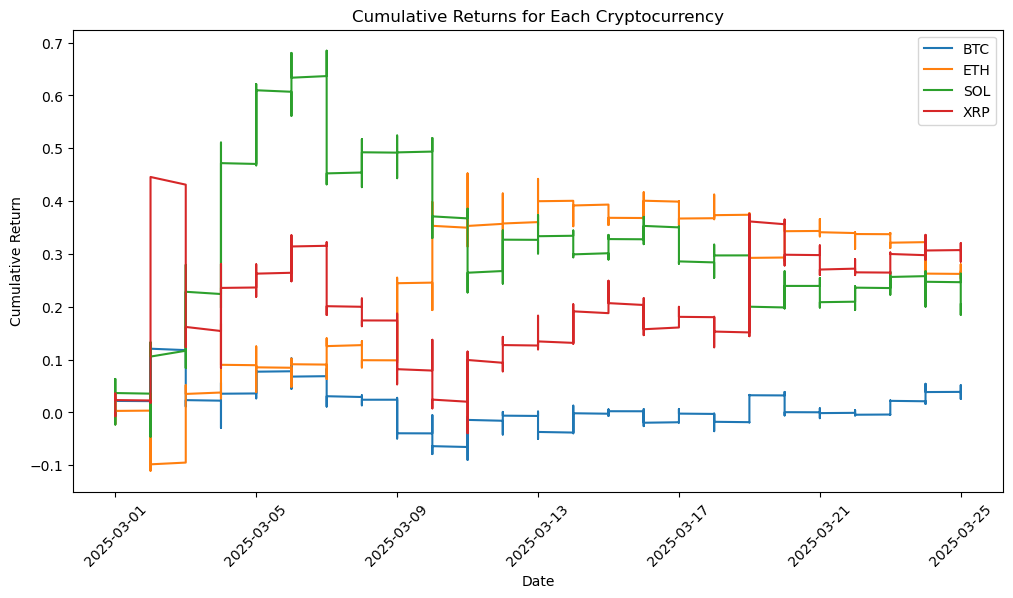

In [211]:

# Combine all trades into a single DataFrame
all_trades_val_df = pd.concat(all_trades_val, ignore_index=True)

# Plot cumulative returns for all stocks
plot_cumulative_returns(all_trades_val_df)

In [212]:
all_trades_val_df['Rolling_Risk'] = all_trades_val_df.groupby('Coin')['Actual_Return'].transform(lambda x: x.rolling(window=10).std())
all_trades_val_df['Rolling_Average'] = all_trades_val_df.groupby('Coin')['Actual_Return'].transform(lambda x: x.rolling(window=10).mean())


In [213]:
all_trades_val_df.to_csv("returns.csv")

In [214]:


# Function to calculate returns for both strategies during the test period
def calculate_strategy_returns_validation(df, all_trades_val_df):
    results = []

    for coin in df['Coin'].unique():
        df_coin = df[df['Coin'] == coin].sort_values('Datetime')

        # Split data (80% train, 20% test)
        split_index = int(len(df_coin) * 0.8)
        df_test = df_coin.iloc[split_index:]  # Select last 20%

        if df_test.empty:
            continue  # Skip if no test data

        # Buy & Hold Strategy Return
        initial_price = df_test['Close'].iloc[0]
        final_price = df_test['Close'].iloc[-1]
        buy_and_hold_return = (final_price / initial_price) - 1

        # Trading Strategy Return (from the logged trades)
        df_trades = all_trades_val_df[all_trades_val_df['Coin'] == coin]
        strategy_return = df_trades['Cumulative_Return'].iloc[-1] if not df_trades.empty else None

        results.append({
            "Coin": coin,
            "Buy & Hold Return (%)": round(buy_and_hold_return * 100, 2),
            "Trading Strategy Return (%)": round(strategy_return * 100, 2) if strategy_return is not None else None
        })

    return pd.DataFrame(results)

# Check if trading results exist
if 'all_trades_df' in globals():
    strategy_returns_df = calculate_strategy_returns(validation, all_trades_val_df)
    print(strategy_returns_df)
else:
    print("Trading strategy results are missing. Please re-run the trading model first.")




  Coin  Buy & Hold Return (%)  Trading Strategy Return (%)
0  BTC                   4.73                         3.81
1  ETH                   6.00                        26.64
2  SOL                  14.39                        20.44
3  XRP                   3.55                        30.72
